In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import mixture, cluster, model_selection

See shape and first few values of dataset. 

In [3]:
alldata = pd.read_csv('room.xyz', sep='\s')
print(alldata.shape)
alldata.head(3)

c:\users\yowza\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


(37062, 6)


,x,y,z,nx,ny,nz
0,-2.0722,-0.8891,0.6603,-0.651641,0.133394,0.746706
1,-2.0685,-0.8891,0.6632,-0.754722,0.145504,0.639705
2,-2.0685,-0.8800,0.6603,-0.585190,0.411254,0.698873


Find range of each attribute, see that they're approximately zero-centered. Values also tell us the 3D image's aspect ratio. 

In [3]:
ranges = pd.concat((alldata.min(), alldata.max(), alldata.min()+alldata.max()), axis=1)
ranges.columns = ['mins', 'maxs', 'diff']
ranges

,mins,maxs,diff
x,-2.427800,2.4278,0.000000
y,-1.821400,1.8214,0.000000
z,-2.112300,2.1123,0.000000
nx,-0.999997,1.0000,0.000003
ny,-0.999987,1.0000,0.000013
nz,-0.999324,1.0000,0.000676


Visualize the points in 3D space. No information on normal vectors included yet. Subsample 5000 of approx. 37000 points to increase response speed of the visualization. There there are some clearly visibile clusters of points. Some of the surfaces formed have edges (e.g. the two largest planar clusters form an edge), which we would like to distinguish despite the similarity in distance. Using normal vectors in the next step will likely help us differentiate separate surfaces connected by an edge. 

<IPython.core.display.Javascript object>


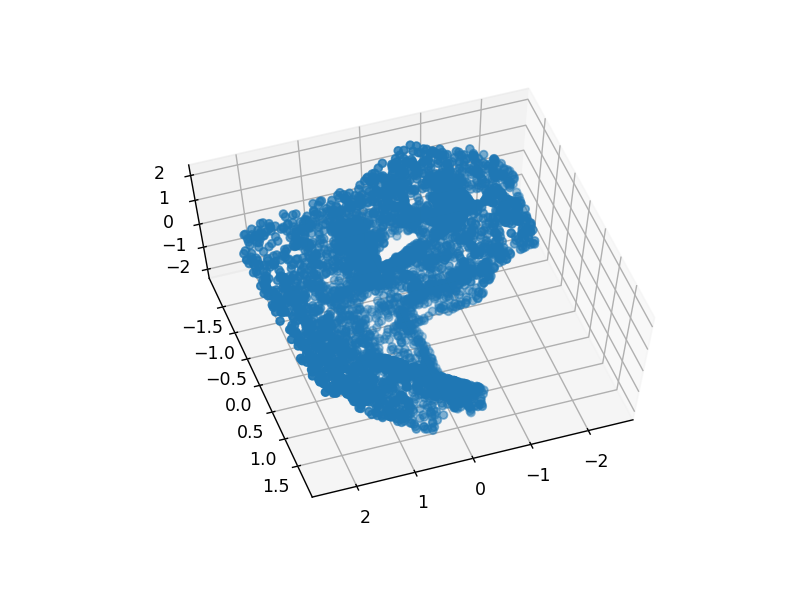

In [7]:
sampdata = alldata.sample(5000) #make things run a bit faster

%matplotlib notebook

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(sampdata['x'], sampdata['y'], sampdata['z'])
ax.view_init(30, 30)

View data with normal vector directions. Use sample so the directions of the vectors are distinguishable. 

<IPython.core.display.Javascript object>


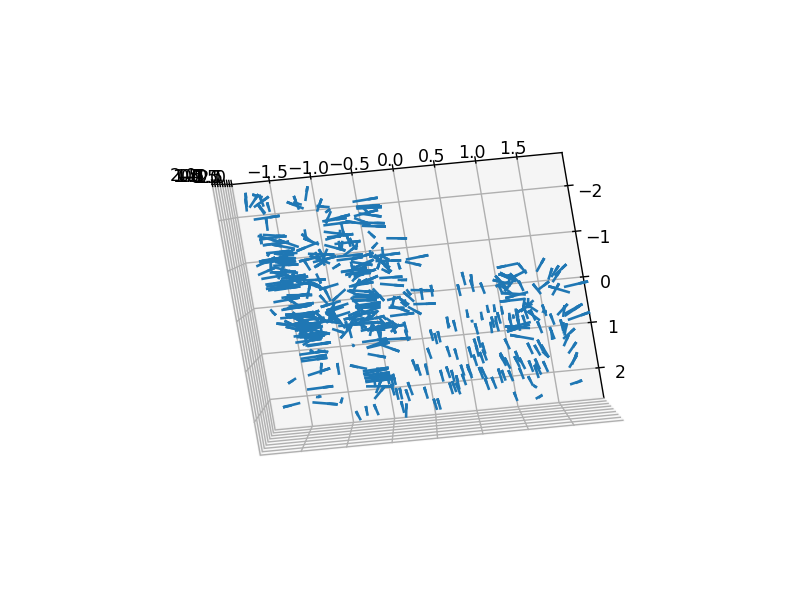

In [9]:
s = alldata.sample(500)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(s['x'], s['y'], s['z'], s['nx'], s['ny'], s['nz'], length=0.3, arrow_length_ratio=0.4)

As noted above this confirms that surfaces at the edge are distinguishable by differences in direction of normal vectors. <br><br>
K-means *could* handle this well because each point will be assessed with respect to each group to minimize whichever distance function we define. The performance here really depends on the distance function we create. However, for the half-cylinder of points, k-means would be less than idea because the "center" would actually give a point that isn't even close to the cluster. The EM algorithm could fail in the same way because it uses "centers" of groups. This could be solved by specifying a large number of clusters, then manually combining them based on geometrical observations. <br><br>
Agglomerative methods should also be considered here. Single-link clustering would work well as long as we can avoid chains of unrelated points. Complete- or average-link clustering would likely fail here since the clusters are of different sizes, and these methods favor smaller clusters, when we have no reason to favor smaller clusters in this application. <br><br>
We will first try single-link clustering with varying $k$ and varying weight given to position in 3D space vs. normal vector. <br>Since k-means is essentially a special case (everywhere symmetric variance) of a GMM, we will then try a GMM with large $k$. <br>We analyze these to see which method is more reasonable then manually combine groups. 

**Agglomerative clustering with equal weights given to distance and normal vector similarity** <br><br>
Start with single-link clustering with $k=5$, and weight $=1$. Weight is a scalar multiplier on the normal vectors, so when weight is higher our distance between points is based more on how similar their normal vectors are and less on how close they are in 3D space. 
1. We see $k=5$ leads to chained groups and is not ideal. Increase $k$ to 15. 
2. Notice that single-link clustering is just isolating outliers and grouping most of the points into a single large group. Single-link and complete-link clustering are the least effective, especially as our sample size of points increases, since each clustering decision is based on a single pair of points. Ward and average linkage seem to work the best here, and we will use ward since its runtime is lower. 
3. Setting `weight=0` groups the bottom of the half-cylinder incorrectly, so we will want to use information from the normal vectors. Setting `weight=20` leads to scattering of points, so we conclude that both position and orientation of each point provide valuable information. Focusing on the half-cylinder and using a manual search for the best value of `weight`, we see that the half-cylinder is mostly grouped well with `weight` approximately 1. However, there is still a portion on the side that is incorrectly grouped. 

<IPython.core.display.Javascript object>


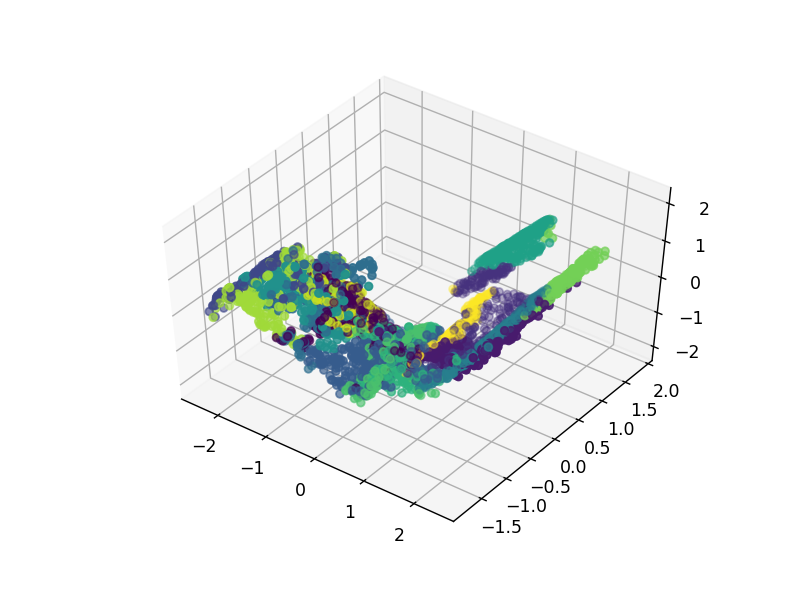

In [21]:
%matplotlib notebook
k = 15
weight = 1

sampdata = alldata.sample(5000)
sampdata[['nx','ny','nz']] *= weight

single = cluster.AgglomerativeClustering(n_clusters=k, linkage='ward')
labels = single.fit_predict(sampdata)
plt.close()
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(sampdata['x'], sampdata['y'], sampdata['z'], c=labels)

**GMM clustering with weights given to distance and normal vector similarity** <br><br>
Using the information from linkage clustering above, start with $k=15$, and weight $=1$. 
1. Setting `weight=2` divides the cylinder into vertical segments. Setting `weight=0.5` cuts off only the very top of the cylinder. After some experimentation we see that setting `weight=0.60` works the best on both the cylinder and the larger surfaces. Very few points are classified unexpectedly. 
2. We can now either manually group similar clusters, or try decreasing k to the desired value. By inspection of the original vectorized datasets (from the quiver plot above) there are about six divisions: half-cylinder, 2 side-walls, floor under each side-wall, and the edge between the side-walls. This is captured by the GMM model with $k=6$, so we can leave this setting and there is no need to manually combine smaller clusters. $k$. 

<IPython.core.display.Javascript object>


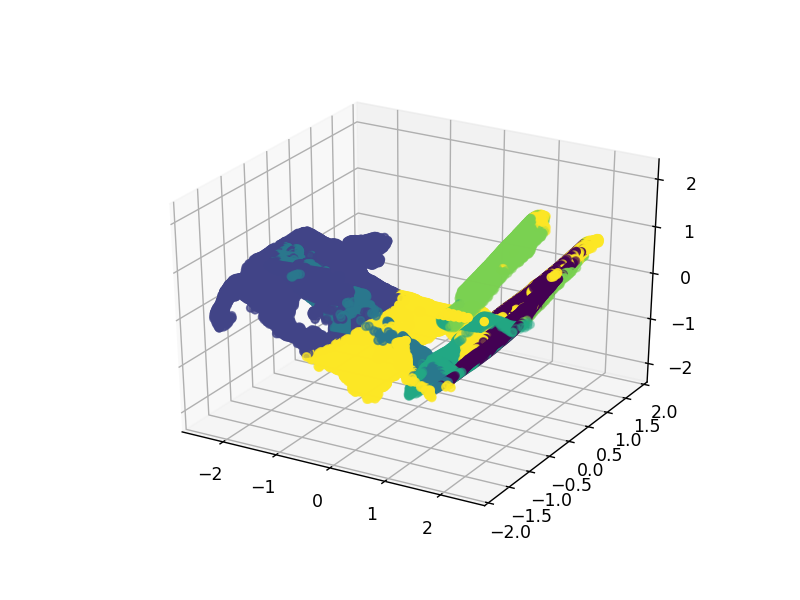

In [23]:
%matplotlib notebook
k = 6
weight = .6

sampdata = alldata.copy(deep=True)#.sample(37000)
sampdata[['nx','ny','nz']] *= weight

gmm = mixture.GaussianMixture(n_components=k).fit(sampdata)
labels = gmm.predict(sampdata)
plt.close()
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(sampdata['x'], sampdata['y'], sampdata['z'], c=labels)

In a supervised setting, we have the correct lables. Obviously, that isn't the case here unless we were to manually label each of the 37000+ points. <br><br>
What we will do instead to produce a test accuracy is assume, by inspection, that the model above classifies the points correctly. To classify a new test point, we have a few options. 
1. Use a distance function that places each test point in the group with the nearest center. Avoid this because it's similar to option (3) but not adaptable to ellipses. 
2. Retrain the entire GMM with the original data and the new point. We now have 6 new groups of points $H_0..H_5$. They may have different centers than the original groups $G_0..G_5$. However, our training data size is large and we only added one new point, so we assume that the centers of these new groups are very similar. We can then associate each new $H_i$ with its nearest $G_j$ by using the match that minimizes the distance between the centers of $H_i, G_j$. Then take the label of the test point $H_n$ and classify that point in the $G$ group nearest to $H_n$. Avoid this because the assumption is unnecessary and because it requires retraining the entire model at test-time. 
3. Train on the training set, then for each new test point use the GMM's mean and variance parameters to estimate probabilities for each of the 6 classes. Assign the test point to the class with the highest probability. Use this because it's simple, and has low memory and runtime complexity. 

In [5]:
#use the results of the fully trained GMM above to determine the "correct" labels
X_train, X_test, y_train, y_actual = model_selection.train_test_split(alldata, labels, test_size=0.2)

Example test run:

In [46]:
probs = gmm.predict_proba(np.array([np.array(X_test)[0]]))

for i in range(6):
    print('% probability of group',i,':', probs[0,i]*100)
print('Actual label:', y_actual[0])

% probability of group 0 : 0.0
% probability of group 1 : 98.12310549609938
% probability of group 2 : 1.8768945023486214
% probability of group 3 : 7.466869510245281e-76
% probability of group 4 : 0.0
% probability of group 5 : 1.5520620259445666e-09
Actual label: 1


Find total test accuracy with an 80-20 train-test split:

In [143]:
k = 6
weight = .6

sampdata = X_train.copy(deep=True)
sampdata[['nx','ny','nz']] *= weight

gmm = mixture.GaussianMixture(n_components=k).fit(sampdata)
preds = gmm.predict(X_test)
    
corr = {0:0, 1:1, 2:0, 3:3, 4:1, 5:1}
y_cop = np.copy(y_actual)
for i in range(6):
    y_cop[np.where(y_cop==i)] = corr[i]

0.2649614160056122

Use hard-coded correspondence between groups to transform predictions, then compare actual labels to predicted labels. As shown below, they match $70.46\%$ of the time for this particular train-test split. We would expect this accuracy to rise if we trained on the entire dataset and attempted to classify new points. 

In [181]:
np.sum(preds == y_cop) / (len(alldata)*0.2)

0.7046300793265339